In [150]:
# Importing Libraries
import pandas as pd
import numpy as np

from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
plt.style.use('seaborn')

from pathlib import Path
import pickle
import json

from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error

import geopandas as gpd

from bokeh.io import output_notebook,show, output_file
from bokeh.plotting import figure,ColumnDataSource
from bokeh.tile_providers import get_provider, CARTODBPOSITRON
from bokeh.palettes import Turbo256,RdYlGn
from bokeh.transform import linear_cmap,factor_cmap
from bokeh.layouts import row,column
from bokeh.models import GeoJSONDataSource, LinearColorMapper,ColorBae,NumeralTickFormatter


import folium
from folium import plugins
from folium.plugins import Heatmap

import geopy.geocoders
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Bing

import reverse_geocoder as rg

import warnings
warning.filterwarnings('ignore')


ImportError: cannot import name 'get_provider'

In [9]:
kc_data = pd.read_csv('Data/kc_house_data.csv')

In [10]:
kc_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [11]:
len(kc_data)

21597

Train-Test split

In [12]:
x = kc_data.drop('price', axis = 1)
y = kc_data['price']

In [19]:
#train-test split (10% to test)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1,random_state=42) 

In [20]:
print(len(x_train),len(x_test),len(y_train),len(y_test))

19437 2160 19437 2160


In [22]:
#setting training set with features and target
df =pd.concat([x_train,y_train],axis=1)

In [23]:
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
13820,9393700065,4/23/2015,3,1.75,1300,5120,1.5,0.0,0.0,4,...,1300,0.0,1925,0.0,98116,47.5589,-122.394,1090,5124,515000.0
1703,7978800621,8/11/2014,3,1.00,1370,56628,1.0,0.0,0.0,3,...,1370,0.0,1942,0.0,98003,47.3058,-122.306,1768,8702,229000.0
4375,223039330,4/7/2015,3,3.00,3250,5093,2.0,0.0,3.0,3,...,3250,0.0,2004,0.0,98146,47.5123,-122.390,2820,7752,1050000.0
11872,5631501323,8/5/2014,3,1.50,1340,13560,1.0,0.0,0.0,3,...,1340,0.0,1968,0.0,98028,47.7410,-122.234,1540,15000,309500.0
9625,1773101050,2/20/2015,3,1.00,960,4560,1.0,0.0,0.0,4,...,960,0.0,1968,NaN,98106,47.5539,-122.365,970,4800,290000.0


## Scrubbing data

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19437 entries, 13820 to 15795
Data columns (total 21 columns):
id               19437 non-null int64
date             19437 non-null object
bedrooms         19437 non-null int64
bathrooms        19437 non-null float64
sqft_living      19437 non-null int64
sqft_lot         19437 non-null int64
floors           19437 non-null float64
waterfront       17299 non-null float64
view             19376 non-null float64
condition        19437 non-null int64
grade            19437 non-null int64
sqft_above       19437 non-null int64
sqft_basement    19437 non-null object
yr_built         19437 non-null int64
yr_renovated     15998 non-null float64
zipcode          19437 non-null int64
lat              19437 non-null float64
long             19437 non-null float64
sqft_living15    19437 non-null int64
sqft_lot15       19437 non-null int64
price            19437 non-null float64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.3+ MB


In [25]:
#modifing date field
df['date'] = pd.to_datetime(df['date'])

In [26]:
df['sqft_basement'].value_counts()

0.0       11553
?           415
600.0       196
500.0       188
800.0       186
          ...  
2196.0        1
266.0         1
2240.0        1
768.0         1
1920.0        1
Name: sqft_basement, Length: 296, dtype: int64

In [27]:
df['sqft_basement'].describe()

count     19437
unique      296
top         0.0
freq      11553
Name: sqft_basement, dtype: object

#### lots of 0's and ?'s in sqft_basement

In [28]:
df['sqft_basement'] = df['sqft_basement'].map(lambda x: float(x.replace('?','0')))

#### dealing with null values

In [29]:
df.isna().sum()

id                  0
date                0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2138
view               61
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3439
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
price               0
dtype: int64

In [30]:
for col in['waterfront','view','yr_renovated']:
    percent_missing = df[col].isnull().sum()/len(df)
    print(f" {col}:{round(percent_missing,3)}")

 waterfront:0.11
 view:0.003
 yr_renovated:0.177


In [40]:
df[['waterfront','view','yr_renovated']].describe()

,waterfront,view,yr_renovated
count,17299.000000,19376.000000,15998.000000
mean,0.007746,0.233072,83.090761
std,0.087673,0.765698,398.696622
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,4.000000,2015.000000


In [43]:
def fill_na_vals(df):
    
    return df.fillna(0)

In [44]:
df = fill_na_vals(df)

In [46]:
df.isna().any()

id               False
date             False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
price            False
dtype: bool

#### Check dupes

In [47]:
dups = df[df.duplicated()]
print(len(dups))

0


##### no duplicate entries

#### Check duplicate ID's

In [49]:
dups = df[df.duplicated(subset=['id'])]
print(len(dups))

139


#### same properties sold multiple times -- leaving as is

## Initial features review

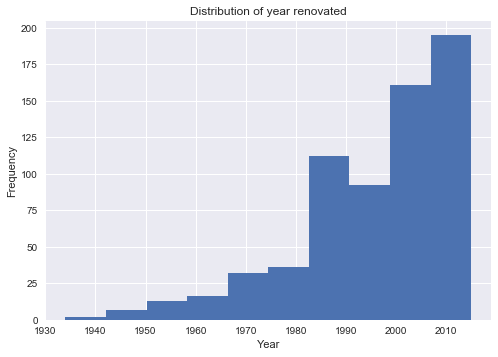

In [63]:
# visualizing yr_renovated 
df[df['yr_renovated'] > 1900]['yr_renovated'].hist()
plt.xlabel ('Year')
plt.ylabel('Frequency')

plt.title('Distribution of year renovated')
plt.show()

Will focus on renovations after 1990 as properties with renovations prior to this date might require some additional work. 

Will also create a new feature labelled 'renovation_feature' that captures post 1990 renovations.

In [64]:
def renovation_feature(df):
    df['was_renovated_post_90'] = df['yr_renovated'].map(lambda x: 1 if x > 1990 else 0)
    df = df.drop('yr_renovated', axis = 1)
    
    return df

In [65]:
df = renovation_feature(df)

Now lets look at yr_built

In [66]:
df['yr_built'].describe()

count    19437.000000
mean      1971.029531
std         29.384345
min       1900.000000
25%       1952.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

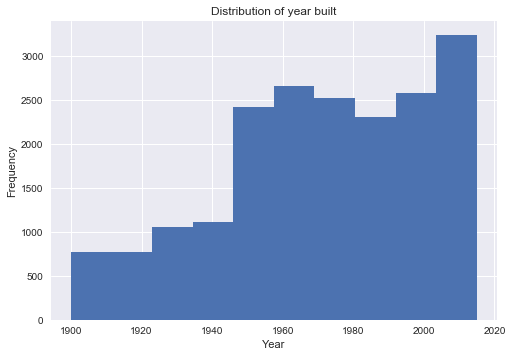

In [67]:
df['yr_built'].hist()
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of year built')
plt.show()

Creating bins to group yr_built to further build features. Additionally will use the summary statistics to define our bins to kepp roughly the same number of data point in our newly created bins

In [71]:
def year_built(df):
    yr_built_bins = [1899,1950,1975,1997,2016]
    yr_built_labels = ['pre_1950', '1950_1975', '1975_1997','1997_2015']
    df['yr_built'] = pd.cut(df['yr_built'],bins = yr_built_bins, labels = yr_built_labels)
    
    return df

In [72]:
df = year_built(df)

Adding a feature called 'has_basement' as seen earlier sqft_basement had a lot of 0 values. Feature will have a value of 1 if the house has a basement else 0 if not. will also drop the original column sqft_basement.

In [73]:
def has_basement(df):
    df['has_basement'] = df['sqft_basement'].map(lambda x: 1 if x > 0 else 0)
    df = df.drop('sqft_basement',axis=1)
    
    return df

In [74]:
df = has_basement(df)

Similar to has_basement, will create a 'Viewed' feature. This will have the value of 1 if viewed and 0 if not yet viewed.  

In [75]:
def viewed(df):
    df['viewed'] = df['view'].map(lambda x: 1 if x>0 else 0)
    df = df.drop('view',axis = 1)
    
    return df

In [76]:
df = viewed(df)

Building out the bath feature

In [77]:
df['bathrooms'].describe()

count    19437.000000
mean         2.115347
std          0.768090
min          0.500000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64

In [79]:
df['bathrooms'].unique()

array([1.75, 1.  , 3.  , 1.5 , 2.  , 2.5 , 2.25, 2.75, 4.  , 3.5 , 3.25,
       7.5 , 4.75, 4.25, 3.75, 0.75, 5.5 , 5.25, 4.5 , 5.  , 1.25, 6.25,
       7.75, 6.5 , 0.5 , 5.75, 6.  , 8.  , 6.75])

From the column names file, bathrooms should contain the indicated number of bathrooms per bedroom. The max of 8 and median of 2.25 doesnt seem to make a lot of sense. However I see that it relates to the overall bathroom count with the float indicating  a toilet but no shower.

To simplify, I'm going to round this feature to the nearest number

In [80]:
def round_bath(df):
    df['bathrooms'] = df['bathrooms'].map(lambda x: int(round(x,0)))
    
    return df

In [81]:
df = round_bath(df)

In [82]:
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,...,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price,was_renovated_post_90,has_basement,viewed
13820,9393700065,2015-04-23,3,2,1300,5120,1.5,0.0,4,6,...,pre_1950,98116,47.5589,-122.394,1090,5124,515000.0,0,0,0
1703,7978800621,2014-08-11,3,1,1370,56628,1.0,0.0,3,7,...,pre_1950,98003,47.3058,-122.306,1768,8702,229000.0,0,0,0
4375,223039330,2015-04-07,3,3,3250,5093,2.0,0.0,3,10,...,1997_2015,98146,47.5123,-122.390,2820,7752,1050000.0,0,0,1
11872,5631501323,2014-08-05,3,2,1340,13560,1.0,0.0,3,7,...,1950_1975,98028,47.7410,-122.234,1540,15000,309500.0,0,0,0
9625,1773101050,2015-02-20,3,1,960,4560,1.0,0.0,4,7,...,1950_1975,98106,47.5539,-122.365,970,4800,290000.0,0,0,0


## Checking outliers

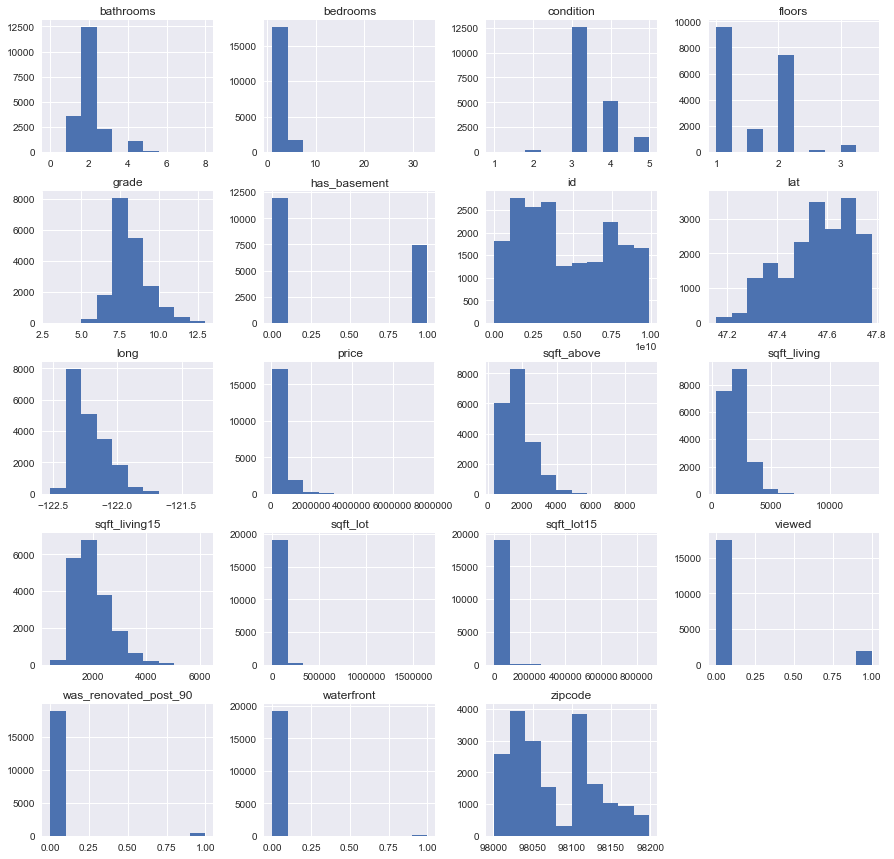

In [83]:
df.hist(figsize = (15,15))
plt.show()

Based on the above, I can see that grade, condition and floors look to be on a resonable scale with no apparent outliers. However, waterfront, was_renovated_post_90, viewed and has_basement all are binary features.

Looking at outliers in the columns bedrooms, bathrooms and sqft 

#### Bedrooms

In [84]:
df['bedrooms'].value_counts()

3     8824
4     6206
2     2488
5     1444
6      241
1      178
7       35
8       11
9        6
10       2
11       1
33       1
Name: bedrooms, dtype: int64

33 bedrooms???? seems suspect

In [85]:
df[df['bedrooms']==33]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,...,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price,was_renovated_post_90,has_basement,viewed
15856,2402100895,2014-06-25,33,2,1620,6000,1.0,0.0,5,7,...,pre_1950,98103,47.6878,-122.331,1330,4700,640000.0,0,1,0


This apprears to be an data error. 33 bed with 2 baths and 1330 sqft_living. Far more likely that this entry should be 3 Bedrooms

In [86]:
df.loc[15856 , 'bedrooms'] =3

Investigating each outlier will be far too time consuming. So I'm going to remove outliers that have a z-score above 3 (where values fall outside 3 standard deviations from the mean)

In case of sqft, as these columns contain continous variable I will be focusing on averages rather than edge cases. For latitude and longitude, i will be focusing on core location.

In [87]:
originalsize = len(df)
originalsize

19437

In [88]:
def remove_outliers(df):
    variables = ['bedrooms','bathrooms','sqft_living','sqft_lot','sqft_above','lat','long','sqft_living15', 'sqft_lot15']
    
    for variable in variables:
        df = df[np.abs(df[variable]-df[variable].mean()) <= (3*df[variable].std())]
        
        return df
    

In [89]:
df = remove_outliers(df)

In [90]:
newsize = len(df)
newsize

19382

In [91]:
round((originalsize-newsize)/originalsize*100,2)

0.28

Less than 1 % reduction!!! 

Focusing now on variable price to see if any adjustments need to be made on outliers...

In [93]:
df['price'].describe().round(2)

count      19382.00
mean      539637.16
std       368123.88
min        78000.00
25%       322000.00
50%       450000.00
75%       642757.50
max      7700000.00
Name: price, dtype: float64

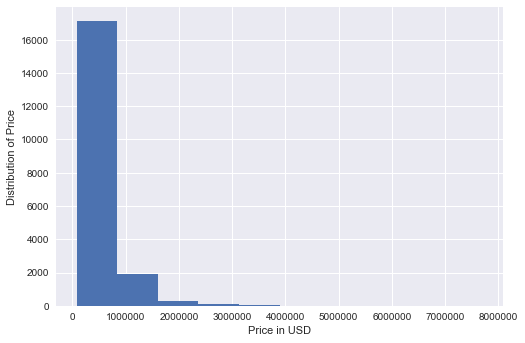

In [94]:
df['price'].hist()
plt.xlabel('Price in USD')
plt.ylabel('Distribution of Price')
plt.show()



In [95]:
# looking for the .9 percentile
for i in range(90,100):
    q=i/100
    quantile = df['price'].quantile(q=q)
    print(f'{q} Percentile: {round(quantile,3)}')



0.9 Percentile: 885000.0
0.91 Percentile: 915000.0
0.92 Percentile: 950000.0
0.93 Percentile: 994000.0
0.94 Percentile: 1060000.0
0.95 Percentile: 1160000.0
0.96 Percentile: 1260000.0
0.97 Percentile: 1390000.0
0.98 Percentile: 1600000.0
0.99 Percentile: 1960000.0


Removing houses above $2mil. these will need to be reviewed seperately as part of a wider project(additional attributes could be applicable to only these types of houses). 

In [96]:
df = df[df['price'] < 2000000]

#### Location

Location is a key feature when it comes to real estate. Looking at the geographical distribution of houses in our dataset to determine where the houses with the highest sales were. 

Building a scatterplot using latitude and longitude features

In [97]:
dfq1 = df.copy()

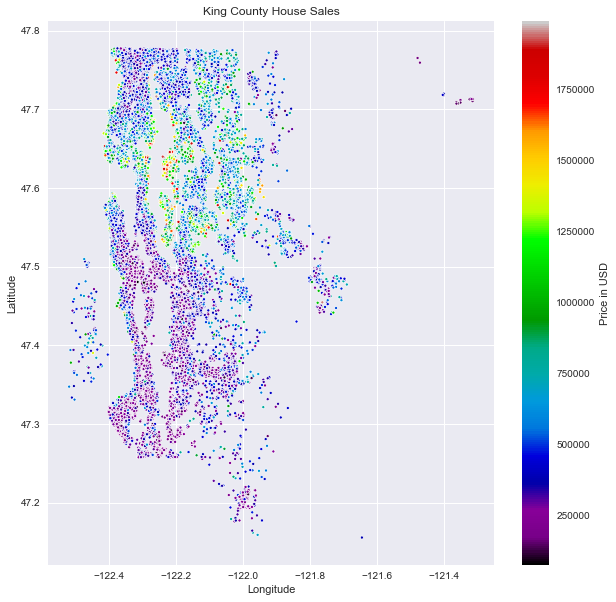

In [123]:
plt.figure(figsize = (10,10))
ax = sns.scatterplot(x = dfq1['long'],y = dfq1['lat'], hue = df['price'], palette = 'nipy_spectral', s=10, legend = None, data = dfq1)
norm = plt.Normalize(dfq1['price'].min(),dfq1['price'].max())
smap = plt.cm.ScalarMappable(cmap='nipy_spectral',norm=norm)
smap.set_array([])

ax.figure.colorbar(smap,label = 'Price in USD')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('King County House Sales')

plt.show()

From the above visualization we can already drawinitial insights based on the houses goegraphical locations. The highest house prices are concentrated in the areas between latitude 47.5 to 47.7 and longitude areas between -122.4 and 122. There is also a clear indication that house prices drop to the south of the above highlighted region. 

Howevere this distribution does not show us enough information around what other impacts affect home prices. for E.g. proximity to water, highways, etc. 

Without the underlying map it is difficult to gain a better understanding of the visualization. Proceeding to map home sales...

In [124]:
dfq1['coord'] = list(zip(dfq1['lat'],dfq1['long']))

In [125]:
#defining func to switch lat/long to mercator coordinates
def x_coords(x, y):
    lat = x
    long = y
    
    r_major = 6378137.00
    x = r_major * np.radians(long)
    scale = x/long
    
    y = 180.0/np.pi *np.log(np.tan(np.pi/4.0 + lat * (np.pi/180.0)/2.0)) * scale
    
    return (x, y)
    

In [126]:
# obtain list of mercators coordinates
mercators = [x_coords(x,y) for x,y in dfq1['coord']]

# create column mercators
dfq1['mercator'] = mercators

# columns mercator_x and mercator_y
dfq1[['mercator_x','mercator_y']] = dfq1['mercator'].apply(pd.Series)

# Preview columns created
dfq1[['zipcode','mercator_x','mercator_y','price']].head()




,zipcode,mercator_x,mercator_y,price
13820,98116,-1.362484e+07,6.033783e+06,515000.0
1703,98003,-1.361504e+07,5.992132e+06,229000.0
4375,98146,-1.362439e+07,6.026099e+06,1050000.0
11872,98028,-1.360703e+07,6.063874e+06,309500.0
9625,98106,-1.362161e+07,6.032958e+06,290000.0


with the updated data, now map these using bokeh. Displaying price and zipcode when mousing over the datapoints would be most beneficial, will use tooltips for this. Also as the default is to display numbers in scienfitic format, will use the NumeralTickFormatter to override as goal is to display price in simple format

In [151]:
# Creating map with Bokeh

# Set map
chosentile = get_provider(CARTODBPOSITRON)

#Set Palette
palette = Turbo

#Set Source
source = CoulmnDataSource(data = dfq1)

#Defining color mapper
color_mapper = linear_cmap(field_name = 'Price', palette = palette, low = df['price'].min(), high = dfq1['price'].max())

#setting tooltips
tooltips= [("Price","@price"),("Zipcode","@zipcode")]


#Figure
p = figure(title = 'King County House Sales', x_axis_type="mercator", y_axis_type = "mercator", x_axis_label = 'Longitude', y_axis_label = 'Latitude', tooltips = tooltips)

#adding map tile
p.add_tile(chosentile)

# adding points using mercator coordinates
p.circle(x = 'mercator_x', y = 'mercator_y', color = color_mapper, source = source)


# Color bar
color_bar = ColorBar(color_mapper = color_mapper['transform'], formatter = NumeralTickFormatter(format="0,0"), label_standoff = 13, width=8, location = (0,0))

# color bar location
p.add_layout (colo_bar, 'right')

# display in notebook
output_notebook()

#show map
show(p)



NameError: name 'get_provider' is not defined

### House prices by Zipcode

Focusing on zipcode data, provided with initial data

In [152]:
dfq1['zipcode'].value_counts()

98103    548
98038    515
98052    514
98115    514
98034    491
        ... 
98010     93
98102     91
98024     73
98148     55
98039     28
Name: zipcode, Length: 70, dtype: int64

All in, 70 unique zipcodes represented in the dataset

Creating a heatmap to explore median home prices per zipcode and to see if zipcode tiers can be set. will use geojson file downloaded from King County GIS Website.(here)

In [155]:
# Load geojson file
geodatafilename = 'Zipcodes_for_King_County_and_Surrounding_Area_Shorelines__zipcode_shore_area.geojson.txt'
gdf = gpd.read_file(geodatafilename)
gdf[:3]

,OBJECTID,ZIP,ZIPCODE,COUNTY,ZIP_TYPE,Shape_Length,Shape_Area,geometry
0,1,98031,98031,033,Standard,117508.231410,2.280129e+08,"POLYGON ((-122.21842 47.43750, -122.21896 47.4..."
1,2,98032,98032,033,Standard,166737.665152,4.826754e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2436..."
2,3,98033,98033,033,Standard,101363.832386,2.566747e+08,"POLYGON ((-122.20571 47.65170, -122.20571 47.6..."


In [156]:

# Extract price and zipcode from our dataset
dfrel = dfq1[['zipcode', 'price']]

# Groupby zipcode and take median price
dfrel = dfrel.groupby(dfrel['zipcode']).median()

# Reset index after groupy
dfrel = dfrel.reset_index()

# Change type to str
dfrel['zipcode'] = dfrel['zipcode'].astype(str)

# Rename column to match type
dfrel = dfrel.rename(columns = {'zipcode' : 'ZIPCODE'})

# Check
dfrel.head()

,ZIPCODE,price
0,98001,261000.0
1,98002,235000.0
2,98003,266500.0
3,98004,1000000.0
4,98005,760000.0


In [159]:
# Merge dataframes
merged = gdf.merge(dfrel, how = 'left', on = 'ZIPCODE')
merged.head()

,OBJECTID,ZIP,ZIPCODE,COUNTY,ZIP_TYPE,Shape_Length,Shape_Area,geometry,price
0,1,98031,98031,033,Standard,117508.231410,2.280129e+08,"POLYGON ((-122.21842 47.43750, -122.21896 47.4...",288000.0
1,2,98032,98032,033,Standard,166737.665152,4.826754e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2436...",249000.0
2,3,98033,98033,033,Standard,101363.832386,2.566747e+08,"POLYGON ((-122.20571 47.65170, -122.20571 47.6...",675000.0
3,4,98034,98034,033,Standard,98550.460072,2.725072e+08,"POLYGON ((-122.17551 47.73706, -122.17551 47.7...",446000.0
4,5,98030,98030,033,Standard,94351.274949,2.000954e+08,"POLYGON ((-122.16746 47.38549, -122.16746 47.3...",282000.0


The geojson file contains additional zipcodes for which we do not have any price information. As such we will drop those additional zip codes.

In [158]:
# Remove entries with null values
merged = merged.dropna()

Let us have a look at descriptive statistics for price to help determine the color_mapper boundaries when plotting the heatmap.

In [160]:
# Get statistics for price
merged['price'].describe().round(3)

count         74.000
mean      487807.412
std       215124.822
min       235000.000
25%       313125.000
50%       449375.000
75%       577412.500
max      1500000.000
Name: price, dtype: float64

We now turn the merged dataframe back into a json file, which will be the data source for our Bokeh plot. We will choose to display median house price and zipcode on hover.

In [161]:
# Turn the merged data frame back into a json file  
merged_json = json.loads(merged.to_json())
json_data = json.dumps(merged_json)

In [162]:
# Plot map using Bokeh

# Set palette
palette = Turbo256

# Set data source
geosource = GeoJSONDataSource(geojson = json_data)

# Define tools
TOOLS = "pan,wheel_zoom,reset,hover,save"

# Define color mapper
color_mapper = LinearColorMapper(palette = palette, low = merged['price'].min(), 
                                 high = merged['price'].max(),  nan_color = '#d9d9d9')


#Set the size and title of the graph
p = figure(title = 'King County Median House Prices per Zipcode', tools = TOOLS, 
           x_axis_label = 'Longitude', y_axis_label = 'Latitude', plot_height = 500 , plot_width = 600, 
           toolbar_location = 'right', tooltips=[("Zip Code","@ZIPCODE"),("Median Price", "@price")])


#Makes it so there are no grid lines
p.grid.grid_line_color = None

# Color sections
p.patches('xs','ys', source = geosource, fill_color = {'field':'price', 'transform' : color_mapper},
         line_color = 'black', line_width = 0.25, fill_alpha = 1)

# Define colorbar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=13, 
                     formatter = NumeralTickFormatter(format="0,0"), width = 8,location = (0,0))

p.add_layout(color_bar, 'right')

output_notebook()

show(p)

NameError: name 'Turbo256' is not defined